🖼 Found 45 images and 32 masks.
 Loaded 001 (1).jpg and 001 (1).mat
 Loaded 001.jpg and 001 (1).mat
 Loaded 002 (1).jpg and 002 (1).mat
 Loaded 002 (2).jpg and 002 (1).mat
 Loaded 002.jpg and 002 (1).mat
 Loaded 003 (1).jpg and 003 (1).mat
 Loaded 003 (2).jpg and 003 (1).mat
 Loaded 003.jpg and 003 (1).mat
 Loaded 004 (1).jpg and 004 (1).mat
 Loaded 004 (2).jpg and 004 (1).mat
 Loaded 004.jpg and 004 (1).mat
 Loaded 005 (1).jpg and 005 (1).mat
 Loaded 005 (2).jpg and 005 (1).mat
 Loaded 005.jpg and 005 (1).mat
 Loaded 006 (1).jpg and 006 (1).mat
 Loaded 006.jpg and 006 (1).mat
 Loaded 007 (1).jpg and 007 (1).mat
 Loaded 007.jpg and 007 (1).mat
 Loaded 008 (1).jpg and 008.mat
 Loaded 008.jpg and 008.mat
 Loaded 009 (1).jpg and 009.mat
 Loaded 009.jpg and 009.mat
 Loaded 010 (1).jpg and 010.mat
 Loaded 010.jpg and 010.mat
 Loaded 011.jpg and 011.mat
 Loaded 012.jpg and 012.mat
 Loaded 013.jpg and 013.mat
 Loaded 014.jpg and 014.mat
 Loaded 015.jpg and 015.mat
 Loaded 016.jpg and 016.mat


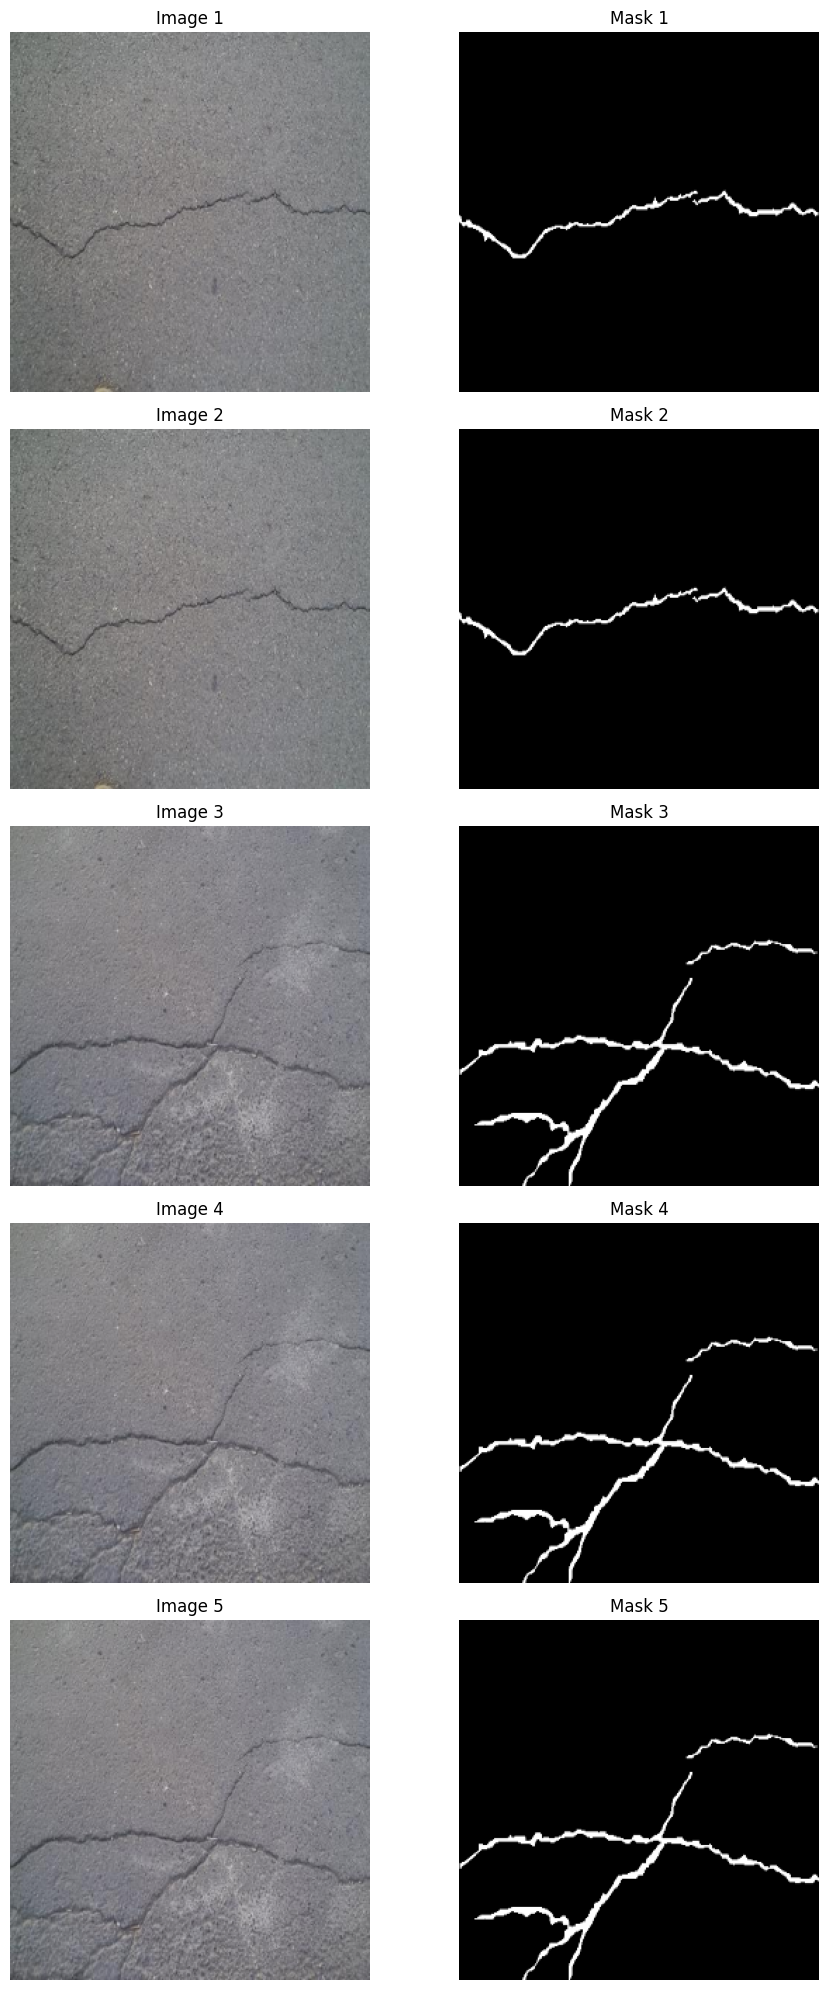

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

IMG_SIZE = 256
IMAGE_DIR = "/content"


# FUNCTION TO LOAD AND PREPROCESS
def load_and_preprocess(img_path, mask_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    # Load .mat mask
    mat = loadmat(mask_path)

    # Try to find the segmentation key automatically
    key_candidates = ["Segmentation", "label", "mask", "groundTruth"]
    mask = None
    for key in mat.keys():
        if any(k.lower() in key.lower() for k in key_candidates):
            mask = mat[key]
            break
    if mask is None:
        for key in mat.keys():
            if not key.startswith("__"):
                mask = mat[key]
                break

    if isinstance(mask, np.ndarray) and mask.dtype.names:
        if "Segmentation" in mask.dtype.names:
            mask = mask["Segmentation"][0][0]
        else:
            raise ValueError(f"⚠️ No 'Segmentation' field found in {mask_path}")

    mask = np.array(mask, dtype=float)
    mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask) + 1e-8)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = np.expand_dims(mask, axis=-1)

    return img, mask


image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(".jpg")])
mask_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(".mat")])

print(f"🖼 Found {len(image_files)} images and {len(mask_files)} masks.")

dataset = []

for img_file in image_files:
    img_id = os.path.splitext(img_file)[0].split()[0]  # '001' from '001 (1).jpg'
    possible_mask = None
    for mfile in mask_files:
        if img_id in mfile:
            possible_mask = os.path.join(IMAGE_DIR, mfile)
            break

    if not possible_mask:
        print(f"Skipping {img_file} — no matching mask found.")
        continue

    img_path = os.path.join(IMAGE_DIR, img_file)
    try:
        img, mask = load_and_preprocess(img_path, possible_mask)
        dataset.append((img, mask))
        print(f" Loaded {img_file} and {os.path.basename(possible_mask)}")
    except Exception as e:
        print(f" Error loading {img_file}: {e}")

print(f"\nSuccessfully loaded {len(dataset)} image–mask pairs.")


def show_samples(dataset, n=5):
    n = min(n, len(dataset))
    plt.figure(figsize=(10, 4*n))
    for i in range(n):
        img, mask = dataset[i]
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')

        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(dataset)
